In [1]:
!pip install --quiet cirq
import cirq
import fractions
import math
import random

import numpy as np
import sympy
from typing import Callable, List, Optional, Sequence, Union
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

     |████████████████████████████████| 47 kB 1.3 MB/s 
     |████████████████████████████████| 328 kB 6.4 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 1.6 MB 45.6 MB/s 
     |████████████████████████████████| 437 kB 47.1 MB/s 
     |████████████████████████████████| 220 kB 47.1 MB/s 
     |████████████████████████████████| 97 kB 3.3 MB/s 
     |████████████████████████████████| 10.1 MB 28.2 MB/s 
     |████████████████████████████████| 145 kB 46.5 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 229 kB 43.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 243 kB 58.9 MB/s 
     |████████████████████████

In [2]:
# Modular exponential operation.
class Modular_Exponential(cirq.ArithmeticOperation):
    """
    Given:
        Target, exponent, base and modulus.
        
    This class applies this:
        ME|target⟩|exponent⟩ = |target * base ** exponent MOD modulus⟩ |exponent⟩     |  0 <= target < modulus
        ME|target⟩|exponent⟩ = |target⟩ |exponent⟩                                    |  modulus <= target
    """
    def __init__(
        self, 
        target: Sequence[cirq.Qid],
        exponent: Union[int, Sequence[cirq.Qid]], 
        base: int,
        modulus: int
    ) -> None:
        self.target = target
        self.exponent = exponent
        self.base = base
        self.modulus = modulus

    def registers(self) -> Sequence[Union[int, Sequence[cirq.Qid]]]:
        return self.target, self.exponent, self.base, self.modulus

    def with_registers(self, *new_registers: Union[int, Sequence['cirq.Qid']],) -> cirq.ArithmeticOperation:
        target, exponent, base, modulus = new_registers
        return Modular_Exponential(target, exponent, base, modulus)

    def apply(self, *register_values: int) -> int:
        target, exponent, base, modulus = register_values
        if target >= modulus:
            return target
        return (target * base**exponent) % modulus

    def __str__(self):
        return "Modular_Exponential"

In [3]:
# Find Order Quantum Circuit.
def create_orderfind_circuit(x: int, n: int, verbose: bool = True) -> cirq.Circuit:
    """
    Returns quantum circuit which computes the order of x modulo n.

    This function computes an eigenvalue of the unitary using Phase Estimation, which internally using Quantum Fourier Transform.
    """
    length = n.bit_length()
    target = cirq.LineQubit.range(length)
    exponent = cirq.LineQubit.range(length, 3 * length + 3)

    c =  cirq.Circuit(
        cirq.X(target[length - 1]),
        cirq.H.on_each(*exponent),
        Modular_Exponential(target, exponent, x, n),
        cirq.qft(*exponent, inverse=True),
        cirq.measure(*exponent, key='exponent'),
    )

    if verbose:
        print(c)

    return c

In [4]:
# Continued Fraction Algorithm 
def continued_fraction_algorithm(result: cirq.Result, x: int, n: int) -> Optional[int]:
    """
    Applied Continued Fraction  to obtain r from various k/r (output of find order).
    """
    # Read the output integer of the exponent register.
    exponent = result.data["exponent"][0]
    exp_num_bits = result.measurements["exponent"].shape[1]
    phase = float(exponent / 2 ** exp_num_bits)

    # Run the continued fractions algorithm to determine f = k / r.
    f = fractions.Fraction.from_float(phase).limit_denominator(n)
    
    # If the numerator is zero, the order finder failed.
    if f.numerator == 0:
        return None
    
    # Else, return the denominator if it is valid.
    r = f.denominator
    if x**r % n != 1:
        return None
    return r

In [5]:
# Find Order.
def find_order(x: int, n: int, verbose:bool = True) -> Optional[int]:
    """
    Finds smallest positive r such that x**r mod n == 1.
    """

    # Check that the integer x is a valid element of the multiplicative group modulo n.
    if x < 2 or n <= x or math.gcd(x, n) > 1:
        raise ValueError(f'Find Order failed due to invalid x={x} and modulus n={n}.')

    # Create the order finding circuit.
    circuit = create_orderfind_circuit(x, n, verbose)
    
    # Sample from the order finding circuit.
    measurement = cirq.sample(circuit)
    
    # Return the processed measurement result.
    return continued_fraction_algorithm(measurement, x, n)

In [6]:
# Find factor if it is a power of prime.
def find_factor_of_prime_power(n: int) -> Optional[int]:
    """
    Returns non-trivial factor of n if n is a prime power, else None.
    """
    for k in range(2, math.floor(math.log2(n)) + 1):
        c = math.pow(n, 1 / k)
        c1 = math.floor(c)
        if c1**k == n:
            return c1
        c2 = math.ceil(c)
        if c2**k == n:
            return c2
    return None

def num_occurrences(n: int, f: int) -> int:
    """
    Returns the number of occurences of the factor f of n.
    """
    count = 1
    f_power = f * f
    while (n % f_power == 0):
        count += 1
        f_power *= f

    return count

# Overall Function
def find_factor(n: int, verbose: bool = True, max_attempts: int = 25) -> Optional[tuple]:
    """
    Returns a non-trivial factor of integer n.
    """
    # If the number is prime, there are no non-trivial factors.
    if sympy.isprime(n):
        return (n, 1)
    
    # If the number is even, two is a non-trivial factor.
    if n % 2 == 0:
        return (2, num_occurrences(n, 2))
    
    # If n is a prime power, we can find a non-trivial factor efficiently.
    p = find_factor_of_prime_power(n)
    if p is not None:
        return (p, num_occurrences(n, p))
    
    for _ in range(max_attempts):
        # Choose a random number between 2 and n - 1.
        a = random.randint(2, n - 1)
        
        # Most likely a and n will be relatively prime.
        d = math.gcd(a, n)
        
        # If a and n are not relatively prime, we found a non-trivial factor.
        if 1 < d < n:
            return (d, num_occurrences(n, d))
        
        # Compute the order r of a modulo n using the order finder.
        r = find_order(a, n, verbose)
        
        # If the order finder failed, try again.
        if r is None:
            continue
        
        # If the order r is not even, try again.
        if r % 2 != 0:
            continue
        
        # Compute the non-trivial factor.
        x = (a ** (r // 2) - 1) % n
        d = math.gcd(x, n)
        if 1 < d < n:
            return (d, num_occurrences(n, d))

    if verbose:
        print(f"Failed to find a non-trivial factor in {max_attempts} attempts.")
    return (None, None)

In [7]:
def runMainCircuit(n: int = -1, verbose: bool = True, max_attempts: int = 25) -> tuple:
    """
    Returns Shor's Algorithm.
    """
    
    start = time.time()

    # Taking the input n from the user
    if(n == -1):
        n = int(input("Enter n: "))
    elif verbose:
        print('n: ', n)

    factors_with_power = []

    answer_found = False

    # Find all the factors of n.
    while(1):
        (f, pow) = find_factor(n, verbose, max_attempts)

        # If the algorithm is not able to find after the max repetitions.
        if f is None:
            break

        factors_with_power.append((f, pow))
        
        # If n is completely factorized return.
        if (f**pow) == n:
            answer_found = True
            break

        n = n // (f ** pow)

    end = time.time()

    if verbose and answer_found:
        print("Factors:")
        print(factors_with_power)

    return (end - start, answer_found)

Code Correctness

In [8]:
# Number to factor
n = 10

# Attempt to find a factor
(time_taken, answer_found) = runMainCircuit(n, True)
print('Time taken: ', time_taken)

n:  10
Factors:
[(2, 1), (5, 1)]
Time taken:  0.0018432140350341797


In [9]:
# Number to factor
n = 15

# Attempt to find a factor
(time_taken, answer_found) = runMainCircuit(n, True)
print('Time taken: ', time_taken)

n:  15
0: ────────Modular_Exponential────────────────────────────
           │
1: ────────#2─────────────────────────────────────────────
           │
2: ────────#3─────────────────────────────────────────────
           │
3: ────X───#4─────────────────────────────────────────────
           │
4: ────H───#5────────────────────qft^-1───M('exponent')───
           │                     │        │
5: ────H───#6────────────────────#2───────M───────────────
           │                     │        │
6: ────H───#7────────────────────#3───────M───────────────
           │                     │        │
7: ────H───#8────────────────────#4───────M───────────────
           │                     │        │
8: ────H───#9────────────────────#5───────M───────────────
           │                     │        │
9: ────H───#10───────────────────#6───────M───────────────
           │                     │        │
10: ───H───#11───────────────────#7───────M───────────────
           │                

In [10]:
# Number to factor
n = 21

# Attempt to find a factor
(time_taken, answer_found) = runMainCircuit(n, True)
print('Time taken: ', time_taken)

n:  21
0: ────────Modular_Exponential────────────────────────────
           │
1: ────────#2─────────────────────────────────────────────
           │
2: ────────#3─────────────────────────────────────────────
           │
3: ────────#4─────────────────────────────────────────────
           │
4: ────X───#5─────────────────────────────────────────────
           │
5: ────H───#6────────────────────qft^-1───M('exponent')───
           │                     │        │
6: ────H───#7────────────────────#2───────M───────────────
           │                     │        │
7: ────H───#8────────────────────#3───────M───────────────
           │                     │        │
8: ────H───#9────────────────────#4───────M───────────────
           │                     │        │
9: ────H───#10───────────────────#5───────M───────────────
           │                     │        │
10: ───H───#11───────────────────#6───────M───────────────
           │                     │        │
11: ───H───#12─

Effect of n on execution time

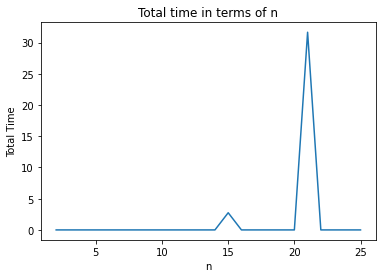

In [ ]:
total_times = []
for n in range(2, 26):
    tt = 0
    for i in range(5):
        (time_taken, answer_found) = runMainCircuit(n, False)
        tt += time_taken
    total_times.append(tt / 5)

x_axis = list(range(2, 26)) 

plt.plot(x_axis, total_times)
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 

Range of time for a given value

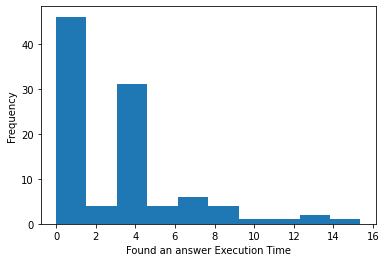

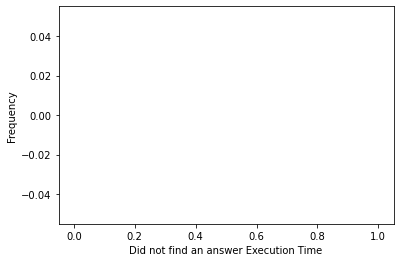

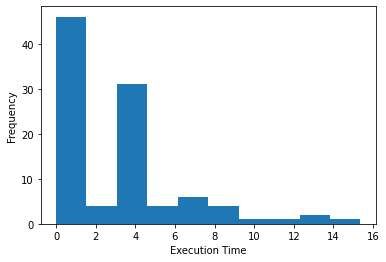

In [ ]:
found_times = []
notfound_times = []

for i in range(100):
    (time_taken, answer_found) = runMainCircuit(15, False)

    if answer_found:
        found_times.append(time_taken)
    else:
        notfound_times.append(time_taken)

plt.hist(found_times)
plt.xlabel('Found an answer Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(notfound_times)
plt.xlabel('Did not find an answer Execution Time')
plt.ylabel('Frequency')
plt.show() 

joinedlist = found_times + notfound_times
plt.hist(joinedlist)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

Success Rate vs Max Iterations

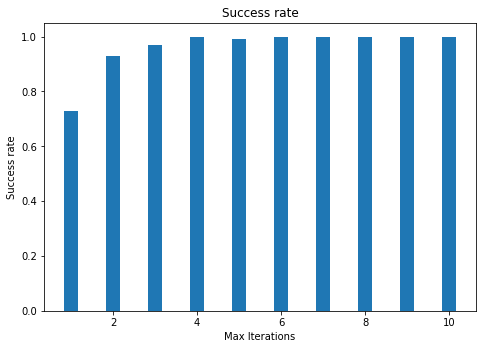

In [ ]:
success = []
for k in range(1, 11):
    count = 0
    for i in range(100):
        (time_taken, answer_found) = runMainCircuit(15, False, k)
        if answer_found:
            count += 1
    success.append(count / 100)

x_axis = list(range(1, 11))

width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_axis, success, width)
ax.set_ylabel('Success rate')
ax.set_xlabel('Max Iterations')
ax.set_title('Success rate')
plt.show()

Success Rate vs n

Outer Loop:   0%|          | 0/24 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

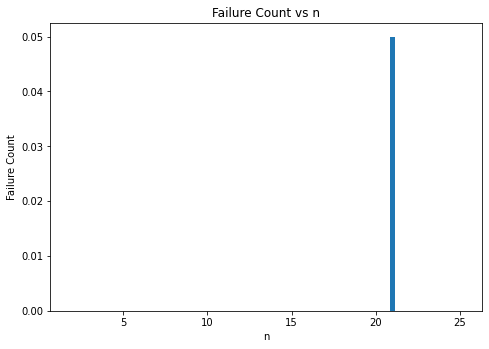

In [ ]:
no_answer_y = []
for n in tqdm_notebook(range(2, 26), desc = 'Outer Loop'):
    no_ans = 0
    for i in tqdm_notebook(range(20), desc = 'Inner Loop'):
        (time_taken, answer_found) = runMainCircuit(n, False, 4)
        if not answer_found:
            no_ans += 1
    no_answer_y.append(no_ans / 20)

x_axis = list(range(2, 26))
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_axis, no_answer_y, width)
ax.set_ylabel('Failure Count')
ax.set_xlabel('n')
ax.set_title('Failure Count vs n')
plt.show()

Outer Loop:   0%|          | 0/24 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/20 [00:00<?, ?it/s]

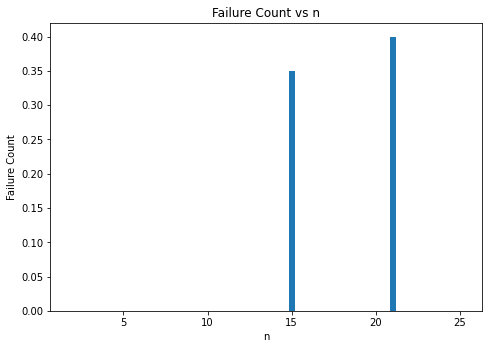

In [ ]:
no_answer_y = []
for n in tqdm_notebook(range(2, 26), desc = 'Outer Loop'):
    no_ans = 0
    for i in tqdm_notebook(range(20), desc = 'Inner Loop'):
        (time_taken, answer_found) = runMainCircuit(n, False, 1)
        if not answer_found:
            no_ans += 1
    no_answer_y.append(no_ans / 20)

x_axis = list(range(2, 26))
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_axis, no_answer_y, width)
ax.set_ylabel('Failure Count')
ax.set_xlabel('n')
ax.set_title('Failure Count vs n')
plt.show()